In [72]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix
import copy
import numpy as np
import matplotlib.pyplot as plt
import os

# Neural Networks and Learning Machines
## Exercise 5 - Convolutional ANN and Transfer learning

In [73]:
epochs = 30

# Introduction
The goal of this exercise is for you to get a better understanding of what convolution is, how it is leveraged to increase the usability and performance of neural networks. The exercise will also teach you about transfer learning and the differences between fine-tuning/feature extraction. 

## Literature
This exercise will rely on the following sections in the [course book](https://www.deeplearningbook.org/).

- Chapter 9
    - Most of it
- Chapter 7
    - Section 7.4 - Dataset augmentation
- Chapter 15
    - Section 15.2 - Transfer learning
    
## Examination
Epochs are predefined to be 30. Feel free to increase/decrease this number depending on the hardware that you are working with. Just make sure that you use the same hyperparameters on tasks 2, 3 and 4. **Make sure you have all examination requirements in order before presenting.**

### Task 1
1. Implementation of same convolution.
2. The resulting image using 3 different filters.

### Task 2
1. The given network trained, validated and tested on the given dataset. Don't forget to make the train/validation/test split of the dataset. This can be achieved programmatically using https://pytorch.org/docs/stable/data.html#torch.utils.data.random_split.
2. Some type of regularization should be used. You should understand how the chosen regularization technique works.
3. Report the training, validation and test accuracy. (Should beat randomly picking)
4. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
5. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 3
1. Fine-tune Resnet18 on the given dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

### Task 4
1. Use Resnet18 as a feature extractor on the dataset.
2. Report the training, validation and test accuracy. (Should beat randomly picking)
3. Calculate and plot the multi-class [confusion matrix](https://en.wikipedia.org/wiki/Confusion_matrix).
4. Add some augmentation techniques which fits well with the data. Does this increase or decrease the validation accuracy?

# Convolution in Neural Networks
A convolutional neural network, CNN for short, is a type of ANN that consists of at least one convolutional layer. CNN's are often used where the input size may vary such as when we are dealing with image input. The architecture of CNNs was inspired by how the visual cortex functions in our brain.

## Task 1: Implement convolution
Implement 2d same convolution without using a built-in convolution function. This should function as described in [this blog post](https://jcbgamboa.github.io/2017/08/12/what-are-convolutions/). One of the great strengths of convolution is that it functions on any sized image, hence it is important that your implementation also does. Same convolution means that the dimensions of the output are the same as the dimensions of the input. This is achieved by padding the input.

Once you have implemented a function that performs 2d convolution, use that to perform convolution over all channels in this image. Show the result using 3 different filters.

To find the padding needed to get the input to be the same space as the output you can use the formula:

$$ n_{out} = \left \lfloor\frac{n_{in}+2p-k}{s} \right \rfloor+1 $$

where $n_{out}$ is the number of output features, $n_{in}$ is the number of input features, $k$ is the kernel size, $p$ is the padding size and $s$ is the stride size. You can assume that the stride is always 1.

True


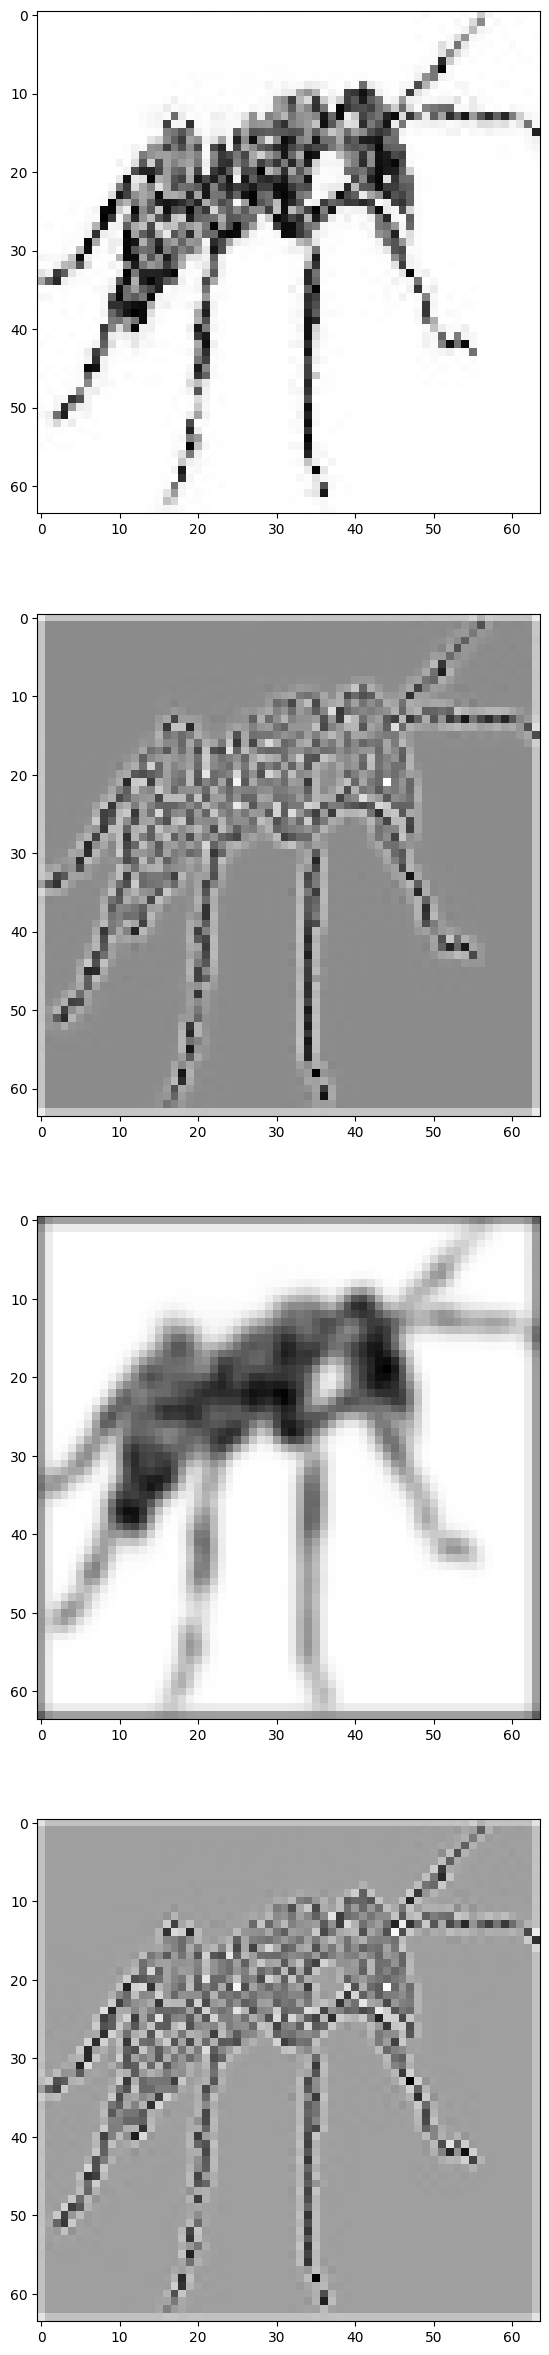

In [74]:
import numpy as np
import math
import cv2
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 30]
plt.rcParams['figure.dpi'] = 100

# Function to calculate padding
def calculate_padding(image, kernel, stride=1):
    return int(((image.shape[0] - 1) / stride - image.shape[0] + kernel.shape[0]) / 2)

# Implementing same convolution in the function below (kernel is a 2d numpy array an example of which can be found in the test)
def conv(image, kernel, stride=1):
    padding = calculate_padding(image, kernel, stride)
    padded_image = np.pad(image, padding)

    # Empty output
    output = np.zeros(image.shape)

    image_height = image.shape[0]
    image_width = image.shape[1]

    # Carry out convolution
    for row in range(0, image_height, stride):
        for col in range(0, image_width, stride):
            input_section = padded_image[row:row + kernel.shape[0], col:col + kernel.shape[0]]
            output[row][col] = np.sum(np.multiply(kernel, input_section))

    return output

# Our test, don't edit
inp = np.array([[1,1,1,1],[1,1,2,1],[1,-3,-4,1],[1,1,1,1]])
kernel = np.array([[0,1,0],[1,2,1],[0,1,0]]) # This is the second input of conv()

# If all are TRUE the convolution is implemented correctly
ans = np.array([[4, 5, 6, 4], [5, 3, 3, 6], [1, -7, -7, 0], [4, 1, 0, 4]])
print(np.array_equal(conv(inp, kernel), ans))

# Loading image using opencv
image_path = r"C:\Users\ahmad\d7046e-ann3\ANN3_dataset\101_ObjectCategories_2classes\ant\image_0032.jpg"  # add your file path here
image = cv2.imread(image_path)

# Check if the image is successfully loaded
if image is None:
    print("Error: Unable to load the image.")
else:
    # Convert the image to grayscale
    image_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Define your 3 kernels
    kernel_1 = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]])    # Edge detection
    kernel_2 = np.array([[1, 4, 6, 4, 1], [4, 16, 24, 16, 4], [6, 24, 36, 24, 6], [4, 16, 24, 16, 4], [1, 4, 6, 4, 1]])
    kernel_2 = np.multiply(kernel_2, 1 / 256)                     # Gaussian blur
    kernel_3 = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])        # Sharpen

    # Perform the convolution (might take a couple of seconds depending on the implementation)
    output1 = conv(image_gray, kernel_1)
    output2 = conv(image_gray, kernel_2)
    output3 = conv(image_gray, kernel_3)

    # Plot the loaded image and the 3 convoluted images
    f, axarr = plt.subplots(4, 1)
    axarr[0].imshow(image_gray, cmap="gray")
    axarr[1].imshow(output1, cmap="gray")
    axarr[2].imshow(output2, cmap="gray")
    axarr[3].imshow(output3, cmap="gray")
    plt.show()


# Computer Vision
Computer vision (CV) is a task within the computer science field that aim is to extract high-level information from static images or video. Such high-level information can be, but is not limited to:
* Object detection - Detect and classify objects within input images
* Anomaly detection - Detect anomalies in the input images
* Semantic segmentation - Classify each pixel in the input image into different classes
* Object recognition - Classifying an entire image depending on what it contains

CV has been studied for multiple decades where early solutions used handwritten feature extractors to extract information from the input. However, with the increase of computing power together with the rise of deep learning algorithms, the main method used to solve CV problems is convolutional neural networks.

In this exercise, we will be taking a closer look at object recognition by first using a randomly initialized network and then utilizing transfer learning. **The dataset we will use for this exercise can be downloaded on canvas**. It is a subset of [this dataset](http://www.vision.caltech.edu/Image_Datasets/Caltech101/). Remember to split the data into separate training, validation and test set.

## Task 2: Implement the missing code and train it on the given dataset.
For task 2, implement the missing parts of the code below. The code should correctly train, validate and test the model. There are some comments guiding you through the process, however if something is unclear try to leverage the documentation for pytorch found [here](https://pytorch.org/docs/stable/index.html). You should also add some type of regularization into your model.

Remember to check the examination requirements in the start of this notebook.

Epoch [1/10], Train Loss: 0.7164, Train Acc: 0.5600, Val Loss: 0.7308, Val Acc: 0.3333
Epoch [2/10], Train Loss: 0.6424, Train Acc: 0.6933, Val Loss: 0.7398, Val Acc: 0.5556
Epoch [3/10], Train Loss: 0.6349, Train Acc: 0.6667, Val Loss: 0.6563, Val Acc: 0.4444
Epoch [4/10], Train Loss: 0.5488, Train Acc: 0.7467, Val Loss: 0.7111, Val Acc: 0.5556
Epoch [5/10], Train Loss: 0.5216, Train Acc: 0.7333, Val Loss: 0.5807, Val Acc: 0.7778
Epoch [6/10], Train Loss: 0.3902, Train Acc: 0.8800, Val Loss: 0.7548, Val Acc: 0.5556
Epoch [7/10], Train Loss: 0.4567, Train Acc: 0.8267, Val Loss: 0.4963, Val Acc: 0.6667
Epoch [8/10], Train Loss: 0.3629, Train Acc: 0.8133, Val Loss: 0.7727, Val Acc: 0.6667
Epoch [9/10], Train Loss: 0.2963, Train Acc: 0.8800, Val Loss: 0.5978, Val Acc: 0.5556
Epoch [10/10], Train Loss: 0.3344, Train Acc: 0.8533, Val Loss: 0.6716, Val Acc: 0.6667
Best Validation Accuracy: 0.7778
Test Accuracy: 0.8810


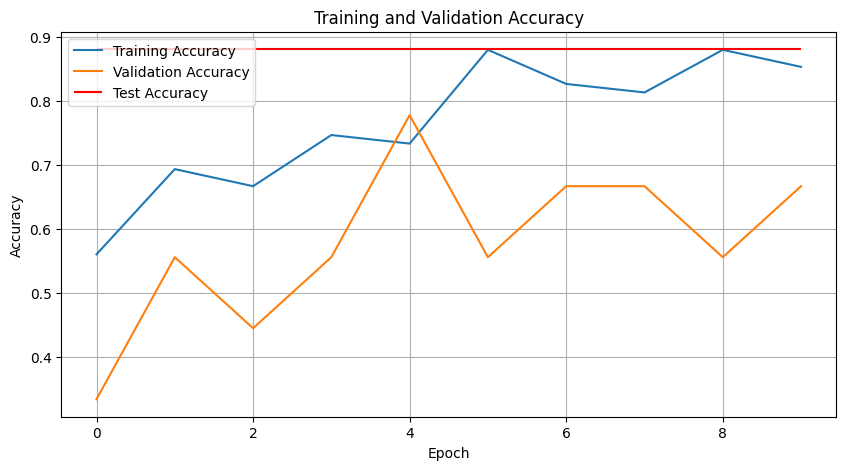

In [75]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 13 * 13, 120)
        self.fc2 = nn.Linear(120, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    best_acc = 0.0
    best_model = None
    train_loss_history = []
    val_loss_history = []
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_total = 0
        train_correct = 0

        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss_history.append(train_loss / train_total)
        train_acc = train_correct / train_total
        train_acc_history.append(train_acc)

        model.eval()
        val_loss = 0.0
        val_total = 0
        val_correct = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        val_loss_history.append(val_loss / val_total)
        val_acc = val_correct / val_total
        val_acc_history.append(val_acc)

        print(f'Epoch [{epoch + 1}/{num_epochs}], '
              f'Train Loss: {train_loss_history[-1]:.4f}, Train Acc: {train_acc:.4f}, '
              f'Val Loss: {val_loss_history[-1]:.4f}, Val Acc: {val_acc:.4f}')

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model

    print(f'Best Validation Accuracy: {best_acc:.4f}')
    return best_model, train_acc_history, val_acc_history

# Hyperparameters
BATCH_SIZE = 8
SHUFFLE = True
LEARNING_RATE = 0.001
NUM_EPOCHS = 10

# Define data transformations
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the dataset
train_data = datasets.ImageFolder(root='C:/Users/ahmad/d7046e-ann3/ANN3_dataset/101_ObjectCategories_2classes', transform=train_transform)
val_data = datasets.ImageFolder(root='C:/Users/ahmad/d7046e-ann3/ANN3_dataset/101_ObjectCategories_2classes', transform=val_transform)

# Perform the training/validation split
train_size = int(0.9 * len(train_data))
val_size = len(train_data) - train_size
train_dataset, val_dataset = random_split(train_data, [train_size, val_size])

# Create DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Initialize the network
model = Net()

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Train the model
best_model, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, NUM_EPOCHS)

# Test the model
# Define test transformation
test_transform = transforms.Compose([
    transforms.Resize(64),
    transforms.CenterCrop(64),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_data = datasets.ImageFolder(root='C:/Users/ahmad/d7046e-ann3/ANN3_dataset/101_ObjectCategories_2classes', transform=test_transform)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

test_accuracy = get_accuracy(best_model, test_loader)
print(f'Test Accuracy: {test_accuracy:.4f}')

# Plotting
plt.figure(figsize=(10, 5))
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.hlines(test_accuracy, 0, len(val_acc)-1, colors='r', label="Test Accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Transfer learning
Transfer learning refers to the practice to use a model which has already been pre-trained on a large dataset to be able to solve task $T_1$, replace the output layer or a few of the upper layers within this model and retrain the model on a smaller dataset to be able to solve task $T_2$. Formally this can be described as the following:

__Def 1:__ Let $D_s$ be the source domain and $T_s$ be the corresponding source task. Let $D_t$ be the target domain and $T_t$ be the corresponding target task. Let $f_t$ be the predictive function for $T_s$. Thus transfer learning aims to improve the learning of $f_t$ in $D_t$ using the already learned knowledge in $D_s$ and $T_s$ where $D_s \neq D_t$ and $T_s \neq T_t$.

The benefit from using transfer learning is that we can train an accurate computer vision model with relatively small amounts of data and computing resources compared to the costly pretraining process of the full convolutional neural network (a few days using multiple GPUs). 

## Fine-tuning and Feature extraction
There are two main ideas when it comes to transfer learning, fine-tuning and feature extraction. When using fine-tuning we allow all weights to be changed during the training phase. However, when we use the pre-trained model as a feature extractor we instead freeze earlier layers of the model, which means that the weights in those layers will not be updated during the training phase and we only update the weights in the upper layers that we have replaced. 

This works because low-level information extracted from the input image is universal between tasks, examples of such information is edge detection, shape detection and pattern detection. This is what the early layers are optimized to do, where later layers extract more abstract features relevant for the task. 

Most of the pre-trained models in PyTorch are trained on [ImageNet](http://www.image-net.org/). 

In this exercise, we use ResNet18 as our model. You should make yourself familiar with the Resnet18 architecture using, for example, [the paper](https://arxiv.org/abs/1512.03385).

## Task 3: Fine-tuning
In task 3 you should fine-tune Resnet18 to the small dataset which is provided above. Some code has been given to you. Remember to re-use functions (such as trained_model) from task 2 to decrease the implementation time.

Remember to check the examination requirements at the start of this notebook.

In [76]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader

# Define transforms
train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the number of classes
num_classes = 2  # Update this according to your dataset

# Define the number of epochs
epochs = 10  # Update this as needed

def load_datasets(batch_size, shuffle=True):
    # Define your dataset loading logic here
    train_dataset = datasets.ImageFolder(root='C:/Users/ahmad/d7046e-ann3/ANN3_dataset/101_ObjectCategories_2classes', transform=train_transform)
    val_dataset = datasets.ImageFolder(root='C:/Users/ahmad/d7046e-ann3/ANN3_dataset/101_ObjectCategories_2classes', transform=val_transform)
    test_dataset = datasets.ImageFolder(root='C:/Users/ahmad/d7046e-ann3/ANN3_dataset/101_ObjectCategories_2classes', transform=test_transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=shuffle)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return train_loader, val_loader, test_loader

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs):
    train_losses = []
    val_losses = []
    best_val_loss = float('inf')
    best_model_weights = None
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        
        epoch_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
        
        val_loss /= len(val_loader.dataset)
        val_losses.append(val_loss)
        
        print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {epoch_loss:.4f}, Validation Loss: {val_loss:.4f}')
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_weights = model.state_dict()
    
    # Load the best model weights
    model.load_state_dict(best_model_weights)
    
    return model, train_losses, val_losses

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    accuracy = 100 * correct / total
    print(f'Test Accuracy: {accuracy:.2f}%')
    
    return accuracy

# Load datasets
train_loader, val_loader, test_loader = load_datasets(batch_size=64, shuffle=True)

# Define ResNet18 model
model_ft = models.resnet18(pretrained=True)

# Modify the model's last layer to match the number of classes in your dataset
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, num_classes)

# Define loss function and optimizer
criterion_ft = nn.CrossEntropyLoss()
optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.001)

# Train the model
trained_model_ft, train_losses, val_losses = train_model(model_ft, criterion_ft, optimizer_ft, train_loader, val_loader, num_epochs=epochs)

# Test the model
tested_model = test_model(trained_model_ft, test_loader)

## Task 4: Feature extraction
In task 4, you should use Resnet18 as a feature extractor. Similarly to task 3, some code has been provided. Remember to re-use as much code as you can. 

Once again, check the examination requirements so you don't forget to implement some required functionality.

In [ ]:
# Use a predefined model as a feature extractor

# We use resnet18 as the model.
model_fe = models.resnet18(pretrained=True)

# Define the necessary parameters
image_size = 224
batch_size = 32
shuffle = True
epochs = 30
learning_rate = 1e-3
num_classes = 2  # Number of classes in dataset

# Do the things required for fine-tuning before training the model

# Define the augmentation transform
augmentation_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomResizedCrop(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset with augmentation
train_loader, validation_loader, test_loader, conf_loader = load_datasets(
    image_size=image_size,
    batch_size=batch_size,
    shuffle=shuffle,
    augmentation=augmentation_transform
)

# Use ResNet18 as a feature extractor
model_fe = models.resnet18(pretrained=True)

# Freeze all parameters of the model
for param in model_fe.parameters():
    param.requires_grad = False

# Replace the fully connected layer with a new one suitable for our classification task
num_ftrs = model_fe.fc.in_features
model_fe.fc = nn.Linear(num_ftrs, num_classes)

# Define loss function and optimizer
criterion_fe = nn.CrossEntropyLoss()
optimizer_fe = optim.Adam(model_fe.parameters(), lr=learning_rate)


# Train the model
trained_model_fe, train_acc, val_acc = train_model(model_fe, criterion_fe, optimizer_fe, train_loader, validation_loader, epochs)

# Test the model
test_accuracy = test_model(trained_model_fe, test_loader)

# Calculate and plot the confusion matrix
targets, preds = get_prediction_labels(trained_model_fe, conf_loader)
conf_matrix = confusion_matrix(targets, preds)
print('Confusion matrix:\n', conf_matrix)

plt.figure(figsize=(5,5))
plt.plot(trainacc, label='Training Accuracy')
plt.plot(valacc, label='Validation Accuracy')
plt.hlines(final_accuracy, 0, len(valacc)-1, label="Test Accuracy")
plt.legend()
plt.show

NameError: name 'models' is not defined